# R4 on DECOY DERMA MNIST

In [15]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
from models.R4_models import DermaNet
from models.robust_regularizer import input_gradient_interval_regularizer
from metrics import worst_group_acc
from models.pipeline import (train_model_with_pgd_robust_input_grad, train_model_with_certified_input_grad,
                             load_params_or_results_from_file, test_model_accuracy, test_delta_input_robustness,
                             write_results_to_file, uniformize_magnitudes_schedule, train_model_with_smoothed_input_grad)
from datasets import derma_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the dataloaders 

In [2]:
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)
batch_size = 256
IMG_SIZE = 64

cuda:1


In [3]:
train_dset = derma_mnist.DecoyDermaMNIST(True, size=IMG_SIZE)
test_dset = derma_mnist.DecoyDermaMNIST(False, size=IMG_SIZE)
print(len(train_dset), len(test_dset))
num_neg = torch.sum(train_dset.dset_labels == 0)
num_pos = torch.sum(train_dset.dset_labels == 1)
print(num_neg, num_pos)
class_weights = [0.4, 2.5 * num_neg / num_pos] # neg, benign (5364), pos, malignant (2646)
print(torch.sum(test_dset.dset_labels == 0), torch.sum(test_dset.dset_labels == 1))

Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
Using downloaded and verified file: /vol/bitbucket/mg2720/R4/examples/datasets/data/dermamnist_64.npz
8010 2005
tensor(5364) tensor(2646)
tensor(1341) tensor(664)


In [4]:
dl_train = derma_mnist.get_dataloader(train_dset, batch_size)
dl_test = derma_mnist.get_dataloader(test_dset, batch_size)

In [5]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, epsilon, elem_idx, has_conv, curr_device):
    channel_to_view = 1
    batch_input, batch_labels, batch_mask = batch_input.to(curr_device), batch_labels.to(curr_device), batch_mask.to(curr_device)
    model.to(curr_device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "binary_cross_entropy", epsilon, 0.0, return_grads=True, regularizer_type="r4",
        batch_masks=batch_mask, has_conv=has_conv, device=curr_device
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    print(f"input lower bound shape: {dx_l.shape}")
    print(f"input upper bound shape: {dx_u.shape}")
    print(f"input gradient shape: {dx_n.shape}")
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    lesion = batch_input[elem_idx].permute(1, 2, 0).cpu().numpy()
    mask = batch_mask[elem_idx].permute(1, 2, 0).cpu().numpy()
    # choose only 1 channel gradient to view, because with 3 channels, the bounds do not represent rgb values
    dx_l_view, dx_u_view, dx_n_view = dx_l[elem_idx][channel_to_view].squeeze(), dx_u[elem_idx][channel_to_view].squeeze(), dx_n[elem_idx][channel_to_view].squeeze()
    ax[0][0].imshow(lesion)
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(mask, cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l_view.cpu().detach().numpy())
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u_view.cpu().detach().numpy())
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    cbu = fig.colorbar(im_dx_u, ax=ax[1][1])
    cbu.ax.invert_yaxis()
    im_dx_n = ax[2][0].imshow(dx_n_view.cpu().detach().numpy())
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [6]:
epsilon = 0.05
model = DermaNet(3, IMG_SIZE, 1)
criterion = torch.nn.BCELoss()
model = model.to(device)

first benign index: 1, first malignant index: 2
input lower bound shape: torch.Size([256, 3, 64, 64])
input upper bound shape: torch.Size([256, 3, 64, 64])
input gradient shape: torch.Size([256, 3, 64, 64])
input lower bound shape: torch.Size([256, 3, 64, 64])
input upper bound shape: torch.Size([256, 3, 64, 64])
input gradient shape: torch.Size([256, 3, 64, 64])


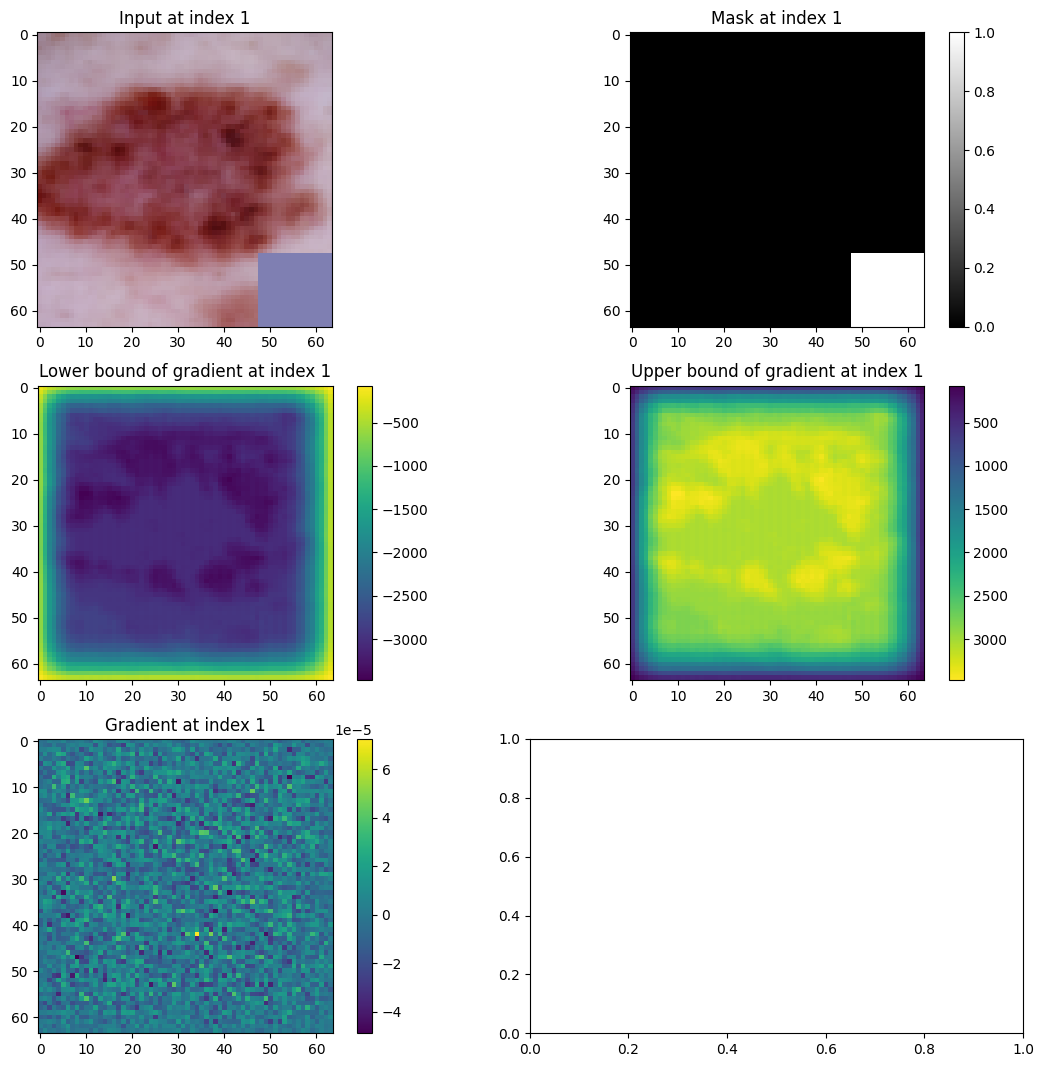

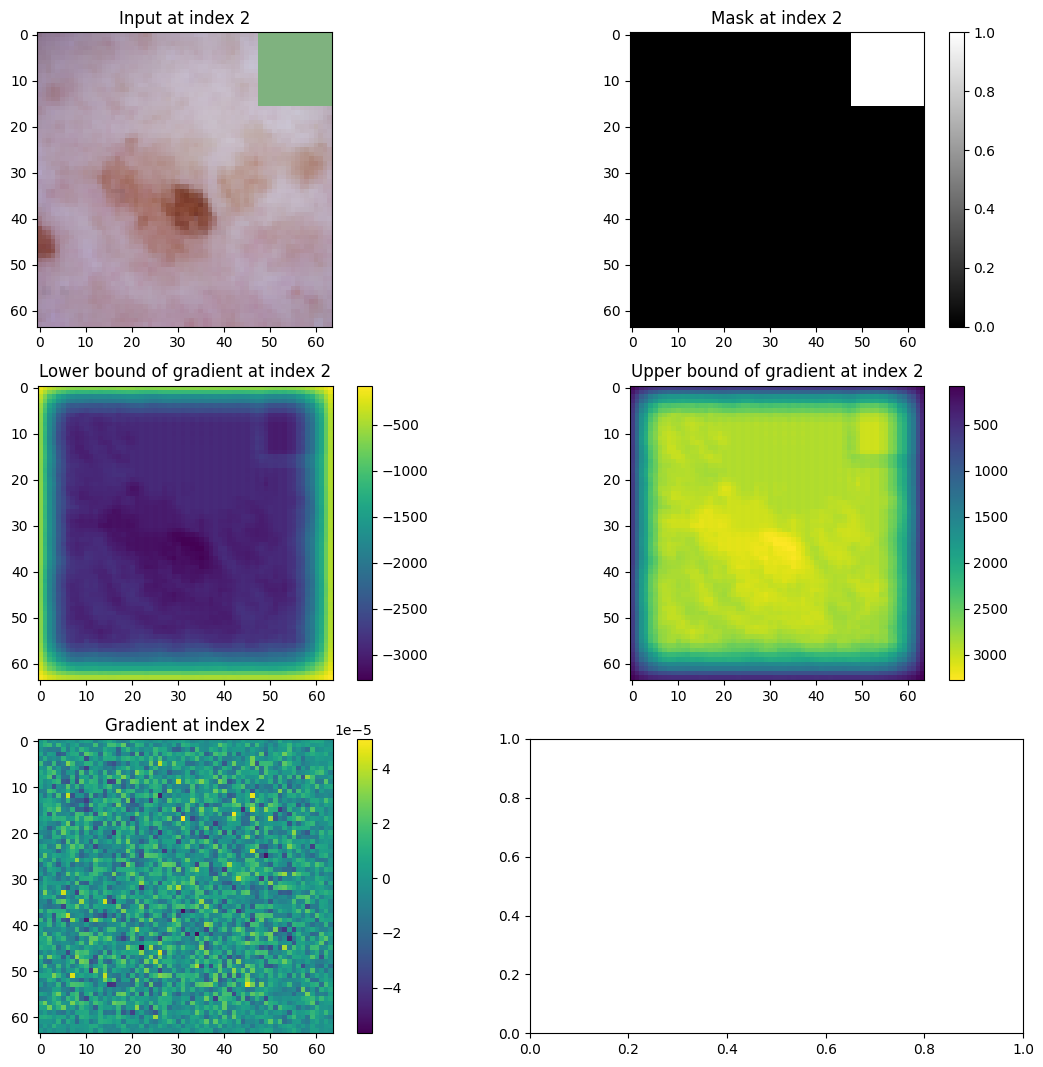

In [7]:
idx_to_visualize = 20

init_batch_train_with_masks = next(iter(dl_train))
first_idx_benign, first_idx_malignant = None, None
for i in range(1, len(dl_train)):
    if init_batch_train_with_masks[1][i] == 1:
        first_idx_malignant = i
    if init_batch_train_with_masks[1][i] == 0:
        first_idx_benign = i
    if first_idx_benign is not None and first_idx_malignant is not None:
        break
print(f"first benign index: {first_idx_benign}, first malignant index: {first_idx_malignant}")
init_batch_test_with_masks = next(iter(dl_test))
visualize_gradient(model, *init_batch_train_with_masks, epsilon, first_idx_benign, True, device)
visualize_gradient(model, *init_batch_train_with_masks, epsilon, first_idx_malignant, True, device)
# visualize_gradient(model, *init_batch_test_with_masks, epsilon, idx_to_visualize, True, device)

## Experiments 

In [8]:
DELTA_INPUT_ROBUSTNESS_PARAM = 1
model_root_save_dir = "saved_experiment_models/performance/derma_mnist"
os.makedirs(model_root_save_dir, exist_ok=True)
methods = ["std", "r3", "r4", "ibp_ex", "ibp_ex+r3", "pgd_r4", "smooth_r3", "rand_r4"]
save_dir_for_method = {method: os.path.join(model_root_save_dir, method) for method in methods}
for method in methods:
    os.makedirs(save_dir_for_method[method], exist_ok=True)

### Standard Training

In [ ]:
std_method = "std"
# Hyperparameters
num_epochs, lr, restarts, epsilon, k, weight_coeff = 10, 1e-3, 4, 0.1, -1, -1
# k is a coefficient for the regularization term
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)
    print(f"========== Training model with method {std_method} restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, std_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                                 "binary_cross_entropy", device, has_conv=True)
    num_robust += num_robust
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[std_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, std_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                        {"epsilon": epsilon,
                         "k": k,
                         "weight_coeff": weight_coeff,
                         "num_epochs": num_epochs,
                         "lr": lr,
                         "restarts": restarts,
                         "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, std_method)

### RRR Training

In [ ]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 12, 1e-4, 4, 0.05, 1e-3, 4e-2
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, rrr_method,
        k, device, True, k_schedule=uniformize_magnitudes_schedule, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[rrr_method], f"run_{i}.pt"))
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, rrr_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, rrr_method)

### R4 Training

In [128]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 12, 3e-4, 4, 0.05, -1, 0.05
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[r4_method], f"run_{i}.pt"))
empty_model = DermaNet(3, IMG_SIZE, 1)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 2, save_dir_for_method[r4_method])
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, r4_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, r4_method)

========== Training model with method r4, restart 0 ==========


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.03s/it, loss=0.429, reg=tensor(0.1802, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.8
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.8
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.56
========== Training model with method r4, restart 1 ==========


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.02s/it, loss=0.457, reg=tensor(0.1800, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.8
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.97
========== Training model with method r4, restart 2 ==========


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.02s/it, loss=0.459, reg=tensor(0.2425, device='cuda:0', grad_fn=<DivBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.8
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.78
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 9.97
========== Training model with method r4, restart 3 ==========


Epoch: 100%|██████████| 12/12 [03:00<00:00, 15.02s/it, loss=0.39, reg=tensor(0.1397, device='cuda:0', grad_fn=<DivBackward0>)] 


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.79
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.79
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 4.4
Worst class accuracy = 0.6928 for class 1


### IBP_EX Training

In [129]:
ibp_ex_method = "ibp_ex"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 1e-3, 4, 0.05, 2e-4, 0.6
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {ibp_ex_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_method,
        k, device, True, weight_reg_coeff=weight_coeff, class_weights=class_weights)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_method], f"run_{i}.pt"))
empty_model = DermaNet(3, IMG_SIZE, 1)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 2, save_dir_for_method[ibp_ex_method])
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "worst_group_acc": wg_acc,
                       "worst_group": wg,
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, ibp_ex_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_method)

========== Training model with method ibp_ex, restart 0 ==========


Epoch: 100%|██████████| 10/10 [01:10<00:00,  7.06s/it, loss=0.389, reg=tensor(0.2240, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.79
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.68
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 281
========== Training model with method ibp_ex, restart 1 ==========


Epoch: 100%|██████████| 10/10 [01:10<00:00,  7.04s/it, loss=0.281, reg=tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.77
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.7
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 148
========== Training model with method ibp_ex, restart 2 ==========


Epoch: 100%|██████████| 10/10 [01:10<00:00,  7.07s/it, loss=0.345, reg=tensor(0.2826, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.77
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.38
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 501
========== Training model with method ibp_ex, restart 3 ==========


Epoch: 100%|██████████| 10/10 [01:10<00:00,  7.05s/it, loss=20.9, reg=tensor(34.8462, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 1
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.67
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 1.05e+03
Worst class accuracy = 0.5718 for class 0


### IBP_EX+R3

In [126]:
ibp_ex_and_r3_method = "ibp_ex+r3"
# hyperparams
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 1e-3, 4, 0.05, 2e-4, 0.5
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {ibp_ex_and_r3_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, ibp_ex_and_r3_method,
        k, device, True, weight_reg_coeff=weight_coeff)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[ibp_ex_and_r3_method], f"run_{i}.pt"))
empty_model = DermaNet(3, IMG_SIZE, 1)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 2, save_dir_for_method[ibp_ex_and_r3_method])
write_results_to_file("experiment_results/derma_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "worst_group_acc": wg_acc,
                       "worst_group": wg,
                       "min_robust_delta": min_robust_delta}, ibp_ex_and_r3_method)
write_results_to_file("experiment_results/derma_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, ibp_ex_and_r3_method)

========== Training model with method ibp_ex+r3, restart 0 ==========


Epoch: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it, loss=0.621, reg=tensor(0.2010, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.76
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.77
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 65.1
========== Training model with method ibp_ex+r3, restart 1 ==========


Epoch: 100%|██████████| 10/10 [02:28<00:00, 14.82s/it, loss=0.581, reg=tensor(0.3122, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.75
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.75
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 120
========== Training model with method ibp_ex+r3, restart 2 ==========


Epoch: 100%|██████████| 10/10 [02:28<00:00, 14.80s/it, loss=0.559, reg=tensor(0.1774, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.77
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.76
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 103
========== Training model with method ibp_ex+r3, restart 3 ==========


Epoch: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it, loss=0.514, reg=tensor(0.2309, device='cuda:0', grad_fn=<AddBackward0>)]


Testing model accuracy for the training set
--- Model accuracy ---
Nominal = 0.78
Testing model accuracy for the test set
--- Model accuracy ---
Nominal = 0.77
--- Delta input robustness ---
Delta Input Robustness = 0
--- Mininimum delta for which the test set is certifiably 1-delta-input-robust ---
Min robust delta = 181
Worst class accuracy = 0.6898 for class 1


# PGD-R4 Training

In [ ]:
pgd_r4 = "pgd_r4"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 14, 1e-3, 1, 0.1, 4e-4, 0.04
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {pgd_r4} restart {i} ==========")
    train_model_with_pgd_robust_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, pgd_r4,
        k, device, weight_reg_coeff=weight_coeff, class_weights=class_weights, num_iterations=10)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_test, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon,
        DELTA_INPUT_ROBUSTNESS_PARAM,  "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[pgd_r4], f"run_{i}.pt"))
empty_model = DermaNet(3, IMG_SIZE, 1)
wg_acc, wg = worst_group_acc(curr_model, dl_test, device, 2, save_dir_for_method[pgd_r4])
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "worst_group_acc": round(wg_acc, 3),
                       "worst_group": wg,
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, pgd_r4)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, pgd_r4)

========== Training model with method pgd_r4 restart 0 ==========


Epoch:   0%|          | 0/14 [00:03<?, ?it/s, loss=1.31, reg=tensor(0.3050, device='cuda:1', grad_fn=<AddBackward0>)]


RuntimeError: The size of tensor a (74) must match the size of tensor b (256) at non-singleton dimension 0

# Smoothed-R3

In [ ]:
smooth_r3 = "smooth_r3"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
num_epochs, lr, restarts, epsilon, weight_coeff, k = 14, 1e-3, 1, 0.1, 4e-4, 0.04
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {smooth_r3} restart {i} ==========")
    train_model_with_smoothed_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, smooth_r3, k,
        device, weight_reg_coeff=weight_coeff, class_weights=class_weights)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device, multi_class=True)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device, multi_class=True)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon,
        DELTA_INPUT_ROBUSTNESS_PARAM, "binarycross_entropy", device)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
    torch.save(curr_model.state_dict(), os.path.join(save_dir_for_method[smooth_r3], f"run_{i}.pt"))
empty_model = DermaNet(3, IMG_SIZE, 1)
wg_acc, wg = worst_group_acc(empty_model, dl_test, device, 2, save_dir_for_method[smooth_r3])
write_results_to_file("experiment_results/decoy_mnist.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "worst_group_acc": round(wg_acc, 3),
                       "worst_group": wg,
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, smooth_r3)
write_results_to_file("experiment_results/decoy_mnist_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, smooth_r3)

# Sample Complexity Experiments

In [ ]:
mask_ratios = [0.8, 0.6, 0.4, 0.2]
methods = ["ibp_ex", "ibp_ex+r3", "r3", "r4"]
for method in methods:
    # Load the params
    params_dict = load_params_or_results_from_file("experiment_results/decoy_mnist_params.yaml", method)
    delta_threshold = params_dict["delta_threshold"]
    epsilon = params_dict["epsilon"]
    k = params_dict["k"]
    weight_coeff = params_dict["weight_coeff"]
    num_epochs = params_dict["num_epochs"]
    lr = params_dict["lr"]
    restarts = params_dict["restarts"]
    for mask_ratio in mask_ratios:
        new_dl_train = derma_mnist.remove_masks(mask_ratio, dl_train)
        train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
        for i in range(restarts):
            # Reinitialize the model
            # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
            torch.manual_seed(i + SEED)
            curr_model = DermaNet(3, IMG_SIZE, 1)

            print(f"========== Training model with method {method} restart {i} and mask ratio {mask_ratio} ==========")
            k_schedule = uniformize_magnitudes_schedule if method in ["r3", "ibp_ex", "ibp_ex+r3"] else None
            train_model_with_certified_input_grad(new_dl_train, num_epochs, curr_model, lr, criterion, epsilon, method,
                                                  k, device, True, weight_reg_coeff=weight_coeff, k_schedule=k_schedule)
            train_acc += test_model_accuracy(curr_model, new_dl_train, device, suppress_log=True)
            test_acc += test_model_accuracy(curr_model, dl_test, device, suppress_log=True)
            n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, delta_threshold,
                                                         "binary_cross_entropy", device, has_conv=True, suppress_log=True)
            num_robust += n_r
            min_robust_delta = min(min_robust_delta, min_delta)
            min_lower_bound += m_l
            max_upper_bound += m_u
        write_results_to_file("experiment_results/decoy_mnist_sample_complexity.yaml",
                            {"train_acc": round(train_acc / restarts, 3),
                             "test_acc": round(test_acc / restarts, 3),
                             "num_robust": round(num_robust / restarts, 3),
                             "min_lower_bound_avg": round(min_lower_bound / restarts, 3),
                             "max_upper_bound_avg": round(max_upper_bound / restarts, 3),
                             "min_robust_delta": min_robust_delta}, method + f"_{int(mask_ratio * 100)}")

# SIZE Experiments

### 28 x 28 Image Size

In [ ]:
IMG_SIZE = 28
train_dset = derma_mnist.DecoyDermaMNIST(True, size=IMG_SIZE)
test_dset = derma_mnist.DecoyDermaMNIST(False, size=IMG_SIZE)
dl_train = derma_mnist.get_dataloader(train_dset, batch_size)
dl_test = derma_mnist.get_dataloader(test_dset, batch_size)
criterion = torch.nn.BCELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Train standard 4 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 30, 1e-4, 4, 0.05, -1, 0.02
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_size.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, IMG_SIZE)
write_results_to_file("experiment_results/derma_size_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, IMG_SIZE)

### 128 x 128 Image Size

In [ ]:
IMG_SIZE = 128
train_dset = derma_mnist.DecoyDermaMNIST(True, size=IMG_SIZE)
test_dset = derma_mnist.DecoyDermaMNIST(False, size=IMG_SIZE)
dl_train = derma_mnist.get_dataloader(train_dset, 125)
dl_test = derma_mnist.get_dataloader(test_dset, 125)
criterion = torch.nn.BCELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Train standard 4 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 1e-4, 4, 0.05, -1, 0.08
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_size.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, IMG_SIZE)
write_results_to_file("experiment_results/derma_size_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": 1}, IMG_SIZE)

In [ ]:
IMG_SIZE = 224
# setup mp_model and devices for this process
train_dset = derma_mnist.DecoyDermaMNIST(True, size=IMG_SIZE, override_dir="/vol/bitbucket/mg2720/derma_mnist_data")
test_dset = derma_mnist.DecoyDermaMNIST(False, size=IMG_SIZE, override_dir="/vol/bitbucket/mg2720/derma_mnist_data")
dl_train = derma_mnist.get_dataloader(train_dset, 55)
dl_test = derma_mnist.get_dataloader(test_dset, 55)
criterion = torch.nn.BCELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Train standard 4 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
num_epochs, lr, restarts, epsilon, weight_coeff, k = 10, 4e-5, 4, 0.05, -1, 0.08
train_acc, test_acc, num_robust, min_robust_delta, min_lower_bound, max_upper_bound = 0, 0, 0, 1e+8, 0, 0
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = DermaNet(3, IMG_SIZE, 1)

    print(f"========== Training model with method {r4_method}, restart {i} ==========")
    train_model_with_certified_input_grad(dl_train, num_epochs, curr_model, lr, criterion, epsilon, r4_method, k, device, True)
    print("Testing model accuracy for the training set")
    train_acc += test_model_accuracy(curr_model, dl_train, device)
    print("Testing model accuracy for the test set")
    test_acc += test_model_accuracy(curr_model, dl_test, device)
    n_r, min_delta, m_l, m_u = test_delta_input_robustness(dl_test, curr_model, epsilon, DELTA_INPUT_ROBUSTNESS_PARAM,
                                "binary_cross_entropy", device, has_conv=True)
    num_robust += n_r
    min_robust_delta = min(min_robust_delta, min_delta)
    min_lower_bound += m_l
    max_upper_bound += m_u
write_results_to_file("experiment_results/derma_size.yaml",
                      {"train_acc": round(train_acc / restarts, 3),
                       "test_acc": round(test_acc / restarts, 3),
                       "num_robust": round(num_robust / restarts, 3),
                       "min_lower_bound": round(min_lower_bound / restarts, 3),
                       "max_upper_bound": round(max_upper_bound / restarts, 3),
                       "min_robust_delta": min_robust_delta}, IMG_SIZE)
write_results_to_file("experiment_results/derma_size_params.yaml",
                      {"epsilon": epsilon,
                       "k": k,
                       "weight_coeff": weight_coeff,
                       "num_epochs": num_epochs,
                       "lr": lr,
                       "restarts": restarts,
                       "delta_threshold": DELTA_INPUT_ROBUSTNESS_PARAM}, IMG_SIZE)